In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dsprites import imshow, make_grid
import tensorflow as tf

import run_dsprites_models as dsvae
ds = dsvae.download_data()
EPOCHS = 100 #35
LATENT_DIM = 10
BATCH_SIZE = 32
TR_SIZE = 550_000 #500_000
#^these need to be the same as the run that produced the model weights

In [2]:
def display_model_random(model, x):
    '''displays a random set of original and reconstructed imgs
    :param model: a vae model to reconstruct from
    :param x: a numpy array representing the images
    '''
    z, *_= model.encode(x) # should return z (latents) and mean/logvar
    x_recon = tf.nn.sigmoid(model.decode(z)).numpy() # generate reconstructed images
    fig = plt.figure(figsize=(20, 20)) 
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    imshow(make_grid(x), title='Original', ax=ax1)
    imshow(make_grid(x_recon), title='Reconstructed', ax=ax2)
    fig.subplots_adjust(wspace=0.01)
    plt.show()
    
def plot_losses(losses):
    '''given an array of losses, plots'''
    plt.plot(losses)
    plt.title("Average epoch loss")
    plt.xlabel("Epoch")
    plt.ylabel("ELBO loss")
    plt.show()
    
def grab_img(set, num):
    '''grabs numth (0index) image from set'''
    return np.array([set[num]])


def step_latents(img, model, size=1, num_var=5):
    """varies each latent up and down by step size
    :param img: nparray of img (1,64,64,1)
    :param model: the model to encode with
    :param size:=1 the step size to vary latents
    :param num_var:=5 int) number of steps up (will automatically 
    do same num steps down)
    
    TODO: take a vector in order to vary the steps non uniformly
    
    :return tensor object of latent encodings for all step variations 
    of each latent (tf.Tensor([[...]...],shape=((num_var*2+1)*LATENT_DIM,LATENT_DIM),
     dtype=float32)
    """
    #x = ds.subset(size=1)
    z, *_ = model.encode(img)
    #print(z)
    z0 = tf.identity(z)
    #print(z0)
    array = [[0,0,0,0,0,0,0,0,0,0]]
    for apos in range(LATENT_DIM):
        array[0][apos] = 1
        zr = tf.identity(z0)
        for step in range(1,num_var+1,size):
            temp1 = [i*step for i in array[0]]
            tempn1 = [i*((-1)*step) for i in array[0]]
            #print([temp1])
            #print([tempn1])
            t1 = tf.add(z0,[temp1])
            tn1 = tf.add(z0,[tempn1])
            zr = tf.concat([tn1,zr,t1],0)
        array[0][apos] = 0
        if apos == 0:
            z = tf.identity(zr)
        else:
            z = tf.concat([z,zr],0)
    return z

def qual_latent_analysis(img, model, size=1, num_var=5):
    """varies each latent up and down by step size
    :param img: nparray of img (1,64,64,1)
    :param model: the model to encode with
    :param size:=1 the step size to vary latents
    :param num_var:=5 int) number of steps up (will automatically 
    do same num steps down)
    
    TODO: take a vector in order to vary the steps non uniformly
    
    :return displays graphic for visual analysis
    """
    z = step_latents(img, model, size, num_var)
    #print(z.shape)
    z_dis_recon = tf.nn.sigmoid(model.decode(z)).numpy()
    imshow(make_grid(z_dis_recon, nrow=num_var*2+1, pad_value=1))

In [3]:
# save vae models and txt file strings as variables
v = ["vae0.5_weights_100e_550ktr.h5","vae1_weights_100-300e_550ktr_suptest.h5",
    "vae2_weights_100e_550ktr.h5", "vae3_weights_100-300e_550ktr_suptest.h5",
    "vae4_weights_100-300e_550ktr_suptest.h5", "vae5_weights_100-300e_550ktr.h5",
    "vae6_weights_100e_550ktr.h5", "vae7_weights_100e_550ktr.h5",
    "vae8_weights_100e_550ktr.h5", "vae9_weights_100e_550ktr.h5",
     "vae10_weights_100e_550ktr.h5"]
vl = ["vae0.5_losses_100e_550ktr.txt","vae1_losses_100-300e_550ktr_suptest.txt",
    "vae2_losses_100e_550ktr.txt", "vae3_losses_100-300e_550ktr_suptest.txt",
    "vae4_losses_100-300e_550ktr_suptest.txt", "vae5_losses_100-300e_550ktr_sup.txt",
    "vae6_losses_100e_550ktr.txt", "vae7_losses_100e_550ktr.txt",
    "vae8_losses_100e_550ktr.txt", "vae9_losses_100e_550ktr.txt",
    "vae10_losses_100e_550ktr.txt"]

In [4]:
accs = np.load("vae13457_repeat_accuracies.npy")
accs5 = np.load("vae5_repeat_accuracies.npy")

In [5]:
print(accs)
print(np.mean(accs, axis=1))
print(np.mean(accs, axis=0))
print([0.5]+list(range(1,11)))
xrange = [1,3,4,5,7]
print(xrange)
print(np.std(accs, axis=1))

[[0.73640001 0.74360001 0.74900001]
 [0.99800003 0.99580002 0.99760002]
 [0.99800003 0.99860001 0.99800003]
 [0.87699997 0.8872     0.88679999]
 [0.99860001 0.99940002 0.99839997]]
[0.74300001 0.99713335 0.99820002 0.88366665 0.9988    ]
[0.92160001 0.92492001 0.92596   ]
[0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[1, 3, 4, 5, 7]
[0.0051614  0.00095685 0.00028283 0.00471688 0.00043207]


Text(0, 0.5, '$\\beta$-VAE disentanglement metric score')

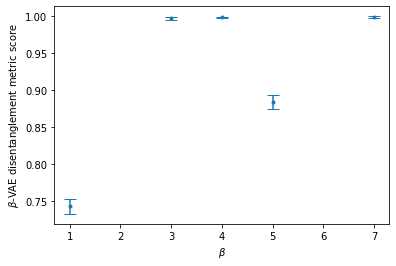

In [6]:
fig = plt.figure()
plt.errorbar(x=xrange,y=(np.mean(accs, axis=1)), yerr=(np.std(accs, axis=1)*2), fmt='o', markersize=3, capsize=6)
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\beta$-VAE disentanglement metric score")

Text(0, 0.5, '$\\beta$-VAE disentanglement metric score')

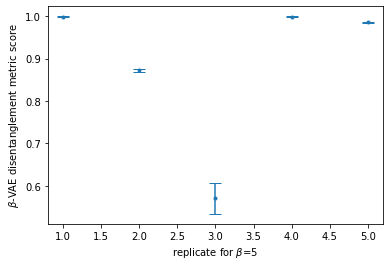

In [7]:
xrange5 = list(range(1,6))
fig = plt.figure()
plt.errorbar(x=xrange5,y=(np.mean(accs5, axis=1)), yerr=(np.std(accs5, axis=1)*2), fmt='o', markersize=3, capsize=6)
plt.xlabel(r"replicate for $\beta$=5")
plt.ylabel(r"$\beta$-VAE disentanglement metric score")